# Описание

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# Задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from lightgbm import plot_importance

import scipy.stats as stats

import time

# Первичный осмотр

In [2]:
files = ('data_arc.csv', 'data_bulk.csv', 'data_bulk_time.csv', 'data_gas.csv', 'data_temp.csv', 'data_wire.csv', 'data_wire_time.csv')
names = ('arc', 'bulk', 'bulk_time', 'gas', 'temp', 'wire', 'wire_time')
data_all = {name : pd.read_csv(file) for name, file in zip(names, files)}

Можно сгенерировать отчеты по таблицам с помощью библиотеки `pandas_profiling`. Например вот так:

```python
from pandas_profiling import ProfileReport

for name, data in data_all.items():
    print('***\t'*20)
    print(name + ' is profiling')
    profile = ProfileReport(data, title = name)
    profile.to_file(name+'.html')
```
В процессе будет сгенерировано несколько отчетов в формате html. Поэтому лучше запускать его на локальной машине.

Более классический осмор таблиц:

In [3]:
for name, data in data_all.items():
    print('***\t'*20)
    print(name)
    print()
    print(data.info())
    display(data.describe(include='all').transpose())
    display(data.head())
    print()

***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
arc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,14876.0,NaN,NaN,NaN,1615.220422,934.571502,1.0,806.0,1617.0,2429.0,3241.0
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Конец нагрева дугой,14876,14876,2019-05-03 11:06:02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,14876.0,NaN,NaN,NaN,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,NaN,NaN,NaN,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
bulk

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
bulk_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3129.0,NaN,NaN,NaN,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0
Bulk 1,252,252,2019-05-03 17:50:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,22,22,2019-05-07 08:36:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,1298,1298,2019-05-03 20:13:36,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,1014,1014,2019-05-03 11:21:30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,77,77,2019-05-07 08:36:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,576,576,2019-05-03 18:52:57,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,25,25,2019-05-07 11:37:42,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 8,1,1,2019-07-05 17:46:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,19,19,2019-05-14 00:04:56,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
gas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,15907.0,NaN,NaN,NaN,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
Время замера,15907,15907,2019-05-03 11:16:18,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Температура,13006.0,NaN,NaN,NaN,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
wire

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	***	
wire_time

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,3081.0,NaN,NaN,NaN,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0
Wire 1,3055,3055,2019-05-03 11:11:41,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 2,1079,1079,2019-05-03 13:32:06,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 3,63,63,2019-05-04 04:47:53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 4,14,14,2019-05-07 08:48:23,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 5,1,1,2019-08-08 16:01:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,73,73,2019-05-07 08:37:20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 7,11,11,2019-07-23 12:42:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 8,19,19,2019-05-14 00:03:32,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 9,29,29,2019-05-04 16:09:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из чего можно заметить:

## arc

Не имеет пропусков. Имеет одно крайне выбивающиеся значение реактивной мощности = -715.504924. Имеет повторяющееся время начала нагрева дугой = 2019-06-10 22:02:03. Названия колонок на русском и не выдерживают "змеиный" стиль.

In [4]:
arc = data_all['arc']
arc.columns = ('key', 'heating_start', 'heating_finish', 'active_power', 'reactive_power')
print('Выбивающаяся реактивная мощность:')
print(arc['reactive_power'].sort_values().head())
display(pd.DataFrame(arc.iloc[9780]).transpose())
print('\nПовторяющееся время начала нагрева:')
display(arc.query('heating_start == "2019-06-10 22:02:03"'))

Выбивающаяся реактивная мощность:
9780   -715.504924
5596      0.020806
2419      0.021154
4914      0.022485
4633      0.022983
Name: reactive_power, dtype: float64


,key,heating_start,heating_finish,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924



Повторяющееся время начала нагрева:


,key,heating_start,heating_finish,active_power,reactive_power
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4876,1052,2019-06-10 22:02:03,2019-06-10 22:04:31,0.623495,0.508767


Заменим выбивающееся значение на среднее значение реактивной мощности для схожих ативных мощностей.

In [5]:
arc.loc[9780, 'reactive_power'] = arc.drop(index=9780).query('0.495782 - 0.01 <= active_power <= 0.495782 + 0.01')['reactive_power'].mean()

И посмотрим на графики без этого экстремального значения:

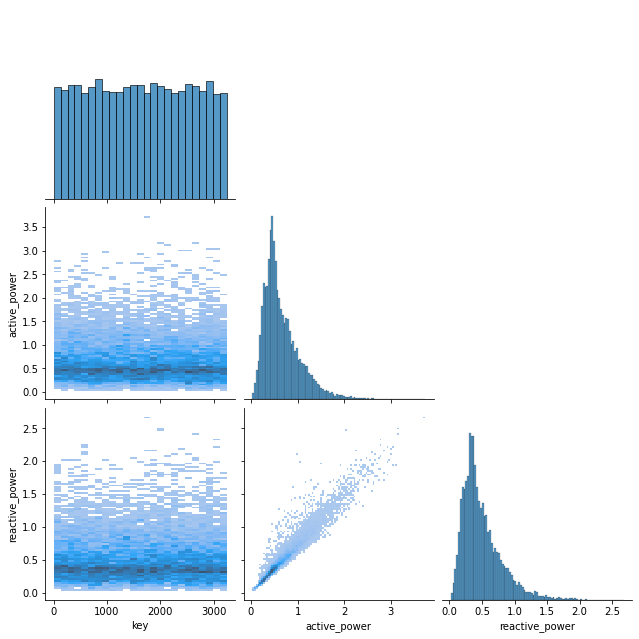


			 PEARSON


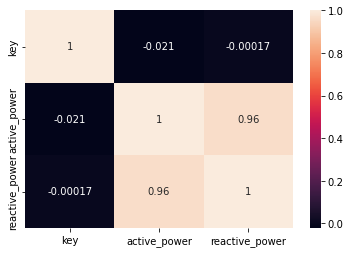


			 KENDALL


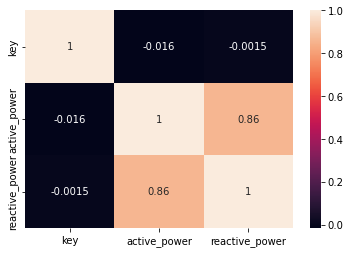


			 SPEARMAN


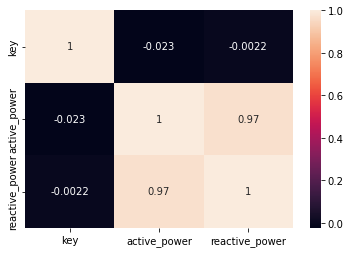

In [6]:
sns.pairplot(arc, kind='hist', corner=True, height=3)
plt.show()
for method in ['pearson', 'kendall', 'spearman']:
    print('\n\t\t\t', method.upper())
    sns.heatmap(arc.corr(method=method), annot=True)
    plt.show()

График показывет, а коэффициенты корреляции подтверждают, что активная и реактивная мощности линейно зависимы.

А вот повторяющееся время начала нагрева выглядит не столь странно. Ведь никто не говорил, что нагревающий электрод всего один, их может быть и несколько. Тогда их одновременный пуск вполне возможен.

## bulk

In [7]:
def make_it_snake(df):
    '''
    Преобразует названия колонок в змеиный формат
    '''
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return None

Очень много пропусков. В некоторых столбцах есть эктремально большие значения. Названия колонок не выдерживают "змеиный" стиль.

In [8]:
bulk = data_all['bulk']
make_it_snake(bulk)

## bulk_time

Ровно столько же пропусков как и в **bulk**. Совпадает не только число пропусков, но и их расположение. Повторяющихся значений нет. Названия колонок не выдерживают "змеиный" стиль.

In [9]:
bulk_time = data_all['bulk_time']
make_it_snake(bulk_time)

Отсюда видно что расположения пропусков полностью совпадают:

In [10]:
display(pd.DataFrame((bulk_time.isna() == bulk.isna()).mean()).transpose())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## gas

Нет пропусков, есть эктремально большие значения. Названия колонок на русском и не выдерживают "змеиный" стиль.

In [11]:
gas = data_all['gas']
gas.columns = ('key', 'gas_1')

## temp

Примерно три тысячи пропусков в значениях температуры. Есть экстремально малые значения. Названия колонок на русском и не выдерживают "змеиный" стиль.

In [12]:
temp = data_all['temp']
temp.columns = ('key', 'time', 'temperature')

В теории пропуски можно заполнить при помощи `interpolate(method='time')`. Требуются дальнейшие разбирательства.

## wire

Очень много пропусков. Есть несколько выбросов. Названия колонок не выдерживают "змеиный" стиль.

In [13]:
wire = data_all['wire']
make_it_snake(wire)

## wire_time

Ровно столько же пропусков как и в **wire**. Совпадает не только число пропусков, но и их расположение. Повторяющихся значений нет. Названия колонок не выдерживают "змеиный" стиль.

In [14]:
wire_time = data_all['wire_time']
make_it_snake(wire_time)

Отсюда видно что расположения пропусков полностью совпадают:

In [15]:
display(pd.DataFrame((wire_time.isna() == wire.isna()).mean()).transpose())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Предобработка

Для дальнейшего удобства можно перевести все временн***ы***е значения в датафреймах в формат Datetime.

In [16]:
for data in data_all.values():
    for column in data.columns:
        if data[column].dtype == 'object':
            data[column] = pd.to_datetime(data[column], format='%Y-%m-%dT%H:%M:%S')

В **bulk** и **wire** большое количество пропусков, и можно рассудить, что те столбцы в которых количество пропусков более 99% не окажут значительного влияния на результат, а значит их можно удалить.

In [17]:
bulk_to_delete = bulk.columns[bulk.notna().mean() < 0.01]
wire_to_delete = wire.columns[wire.notna().mean() < 0.01]
print('Cтолбцы в которых количество пропусков более 99% в таблице bulk', bulk_to_delete)
print('Cтолбцы в которых количество пропусков более 99% в таблице wire', wire_to_delete)

Cтолбцы в которых количество пропусков более 99% в таблице bulk Index(['bulk_2', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], dtype='object')
Cтолбцы в которых количество пропусков более 99% в таблице wire Index(['wire_4', 'wire_5', 'wire_7', 'wire_8', 'wire_9'], dtype='object')


Эти столбцы и удалим из таблиц **bulk** и **wire**.

In [18]:
bulk = bulk.drop(bulk_to_delete, axis=1)
wire = wire.drop(wire_to_delete, axis=1)

Можно рассудить, что все пропуски в **bulk** и **wire** - это те случаи когда это конкретное вещество в смесь не добавляли. А значит по сути добавили 0 объемов данного вещества, тогда все пропуски в этих таблицах можно заменить нулями.

In [19]:
bulk = bulk.fillna(0)
wire = wire.fillna(0)

# Исследовательский анализ данных

**arc**

Анализ был проведен выше.

**temp**

Посмотрим для каких временных промежутков характерны пустые значения.

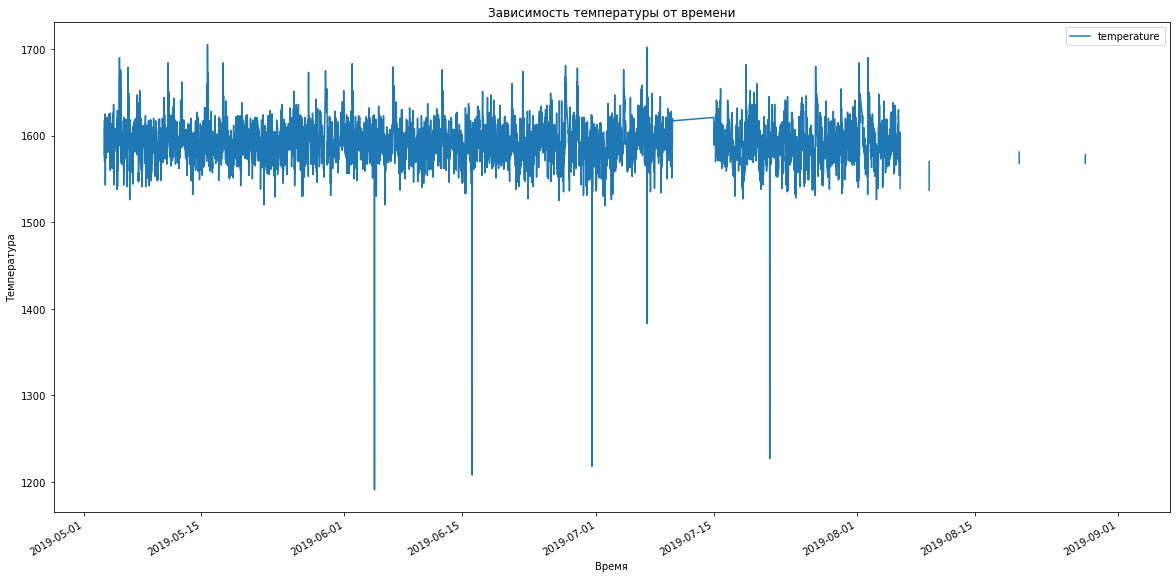

In [20]:
temp.plot(x='time', y='temperature', kind='line', figsize=(20, 10))
plt.title('Зависимость температуры от времени')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.show()

Видно что пропуски в основном сконцентрированны в области от ~ 2019-08-06 до 2019-09-02.

Создадим суммарную таблицу, в которой будут: средняя температура, температура при первом измерении и температура при последнем измерении.

In [21]:
temp_summary = pd.DataFrame(temp.groupby('key', dropna=False)['temperature'].mean())
temp_summary.columns = ['mean_temperature']
temp_summary['first_temperature'] = temp.sort_values('time').groupby('key', dropna=False)[['key', 'temperature']].head(1).set_index('key')
temp_summary['last_temperature'] = temp.sort_values('time').groupby('key', dropna=False)[['key', 'temperature']].tail(1).set_index('key')
temp_summary.head()

,mean_temperature,first_temperature,last_temperature
key,,,
1,1601.400000,1571.0,1613.0
2,1593.500000,1581.0,1602.0
3,1597.800000,1596.0,1599.0
4,1616.333333,1601.0,1625.0
5,1589.000000,1576.0,1602.0


Уберем те партии для которых проводилось лишь одно измерение.

In [22]:
temp_summary = temp_summary[temp.groupby('key')['time'].count() != 1]

Посмотрим сколько пропусков есть в этой таблице.

In [23]:
temp_summary.isna().sum()

mean_temperature       0
first_temperature      0
last_temperature     739
dtype: int64

Из чего видно, что первое измерение присутствует всегда, в то время как поседнее по неясной причине отсутствует в 739 случаях. Все эти случаи нельзя рассматривать при дальнейшем построении модели, так как конечная температура стали - это целевой признак, а без целевого произнака нельзя строить прогноз.

На следующих этапах все эти пропуски будут удалены из датафрейма.

Выводы по анализу других таблиц напашиваются сами собой после первичного осмотра:

**bulk**, **bulk_time**, **wire** и **wire_time**:

Из них видно, что одной партии стали соответсвует только одно добавление одного или нескольких сыпучих вешеств и одно добавление одной или нескольких проволок. А значит время добавления порошка или проволоки не столь важно как объем добавленного вещества (поскольку все порошки или все проволоки всегда добавляются одновременно). Из чего следует, что таблицы **bulk_time** и **wire_time** вовсе не нужны.

**gas**

Для каждой партии характерен свой объем газа. Присутствуют несколько эктремально больших значений выбивающихся из выборки.

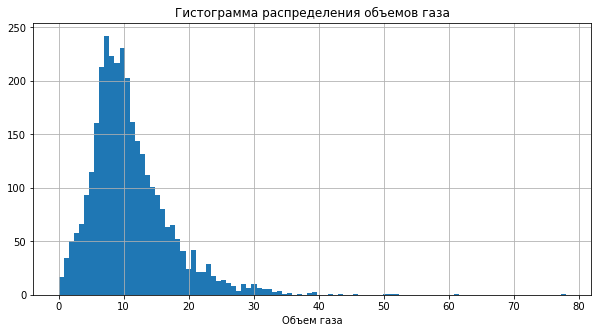

In [24]:
gas['gas_1'].hist(bins=100, figsize=(10, 5))
plt.title('Гистограмма распределения объемов газа')
plt.xlabel('Объем газа')
plt.show()

# Возможное преобразование таблиц для дальнейшего предсказания

Все параметры из **arc** могут быть скомбинированы в один столбец следующим образом:
1. Рассчитать длительность работы электрода для каждого эпизода нагревания;
2. Рассчитать полную мощность по следующей формуле:
$$Полная\ мощность=\sqrt[2]{Активная\ мощность^2 + Реактивная\ мощность^2}$$
3. Рассчитать энергопотребление умножив полную мощность на длительность работы электрода.

Поскольку конкретная величина измерения мощности неизвестна будем считать её условно.

In [25]:
arc['heating_duration'] = (arc['heating_finish'] - arc['heating_start']).dt.seconds
arc['apparent_power'] = (arc['active_power'] ** 2 + arc['reactive_power'] ** 2) ** 0.5
arc['electric_energy_consumption'] = arc['apparent_power'] * arc['heating_duration']
arc.head()

,key,heating_start,heating_finish,active_power,reactive_power,heating_duration,apparent_power,electric_energy_consumption
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,119.471318


Далее можно все энергопотребление просуммировать по партиям.

In [26]:
from_arc = arc.groupby('key')['electric_energy_consumption'].sum()
from_arc.head()

key
1    1442.377754
2     881.233565
3     525.066777
4     796.911309
5    1199.137958
Name: electric_energy_consumption, dtype: float64

Таким образом получится один столбец в котором учтены все данные из таблицы **arc**.

In [27]:
from_bulk = bulk.set_index('key')
from_bulk.head()

,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_10,bulk_11,bulk_12,bulk_14,bulk_15
key,,,,,,,,,,
1,0.0,0.0,43.0,0.0,0.0,0.0,0.0,206.0,150.0,154.0
2,0.0,0.0,73.0,0.0,0.0,0.0,0.0,206.0,149.0,154.0
3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,205.0,152.0,153.0
4,0.0,0.0,81.0,0.0,0.0,0.0,0.0,207.0,153.0,154.0
5,0.0,0.0,78.0,0.0,0.0,0.0,0.0,203.0,151.0,152.0


In [28]:
from_gas = gas.set_index('key')
from_gas.head()

,gas_1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Из таблицы **temp_summary** возьмем начальную и конечную температуры сплава.

In [29]:
from_temp = temp_summary[['first_temperature', 'last_temperature']]
from_temp.head()

,first_temperature,last_temperature
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [30]:
from_wire = wire.set_index('key')
from_wire.head()

,wire_1,wire_2,wire_3,wire_6
key,,,,
1,60.059998,0.00000,0.0,0.0
2,96.052315,0.00000,0.0,0.0
3,91.160157,0.00000,0.0,0.0
4,89.063515,0.00000,0.0,0.0
5,89.238236,9.11456,0.0,0.0


И объеденим все в одну таблицу.

In [31]:
full = pd.concat((from_arc, from_bulk, from_gas, from_temp, from_wire), axis=1)

Вполне вероятно, что из-за объединения по типу outer в ней образуются пропуски. Проверим сколько их.

In [32]:
full.isna().sum()

electric_energy_consumption     27
bulk_1                         112
bulk_3                         112
bulk_4                         112
bulk_5                         112
bulk_6                         112
bulk_10                        112
bulk_11                        112
bulk_12                        112
bulk_14                        112
bulk_15                        112
gas_1                            2
first_temperature               27
last_temperature               766
wire_1                         160
wire_2                         160
wire_3                         160
wire_6                         160
dtype: int64

Все пропуски в *last_temperature* делают невозможным посстроение модели, поэтому их необходимо удалить.

Кроме того, видно, что появились пропуски в *electric_energy_consumption* и *temperature*, их объяснить нечем, поэтому лучше их удалить.

Все оставшиеся пропуски значатся в подаче материалов. А значит их можно заменить на 0, исходя из предположения, что для данной партии материалов не подавалось вовсе. Но в таком случае получается, что эта к этой партии стали не добавляли ничего, что само по себе является экстремальным случаем, а значит, что эти пропуски тоже лучше удалить.

In [33]:
full = full.dropna()
full.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
electric_energy_consumption,2329.0,902.928819,650.753488,15.158096,465.235480,767.817794,1165.650557,10630.980668
bulk_1,2329.0,3.427651,12.412132,0.000000,0.000000,0.000000,0.000000,185.000000
bulk_3,2329.0,47.348218,75.310430,0.000000,0.000000,0.000000,80.000000,454.000000
bulk_4,2329.0,37.303564,58.643238,0.000000,0.000000,0.000000,77.000000,281.000000
bulk_5,2329.0,2.640189,22.402293,0.000000,0.000000,0.000000,0.000000,603.000000
bulk_6,2329.0,22.430228,55.790873,0.000000,0.000000,0.000000,0.000000,503.000000
bulk_10,2329.0,5.052812,20.917800,0.000000,0.000000,0.000000,0.000000,159.000000
bulk_11,2329.0,4.245170,22.515487,0.000000,0.000000,0.000000,0.000000,313.000000
bulk_12,2329.0,208.415629,157.062272,0.000000,105.000000,206.000000,282.000000,1849.000000
bulk_14,2329.0,153.853585,81.404354,0.000000,105.000000,149.000000,204.000000,636.000000


Чтобы оценить мультиколлинеарность построим корреляционную матрицу.

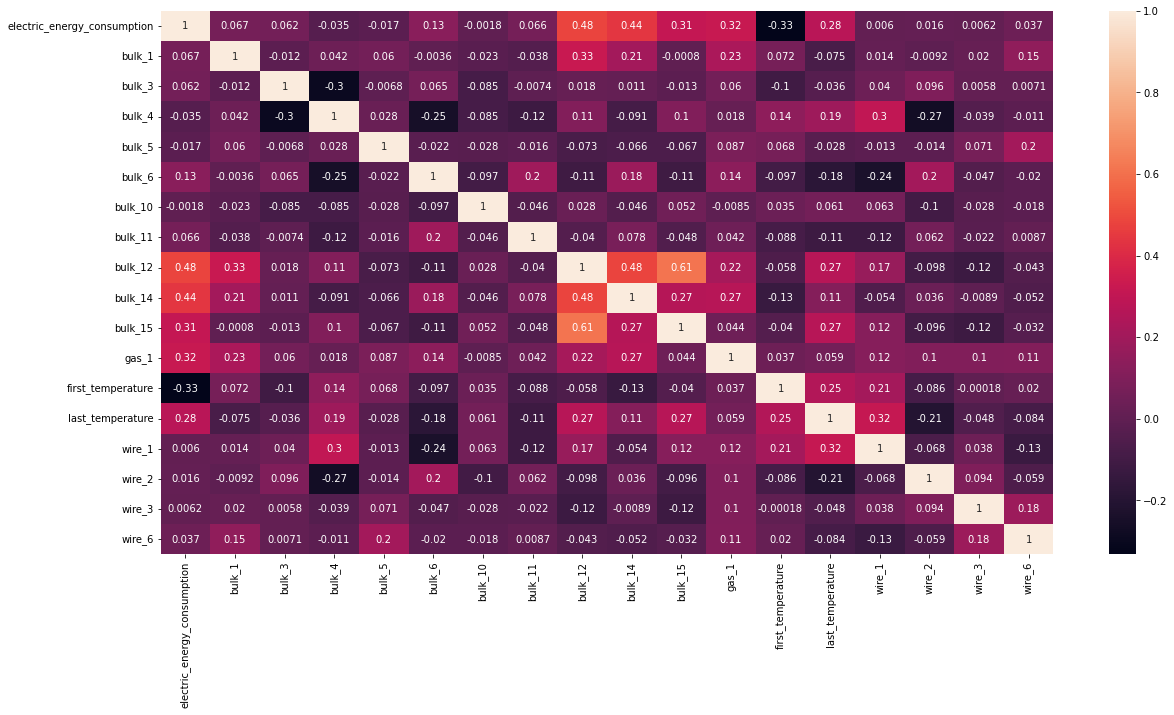

In [34]:
plt.figure(figsize=(20, 10))
sns.heatmap(full.corr(), annot=True)
plt.show()

Из матрицы видно, что лишь одна пара признаков bulk_15 и bulk_12 приближаются к тому, чтобы быть линейно зависимыми. Они имеют среднюю корреляцию, поэтому их нельзя назвать взаимозаменяемыми, а значит оба необходимо оставить.

Важно, чтобы у предсказываемого признака last_temperature не было выбросов, поэтому удалим экстремальные значения.

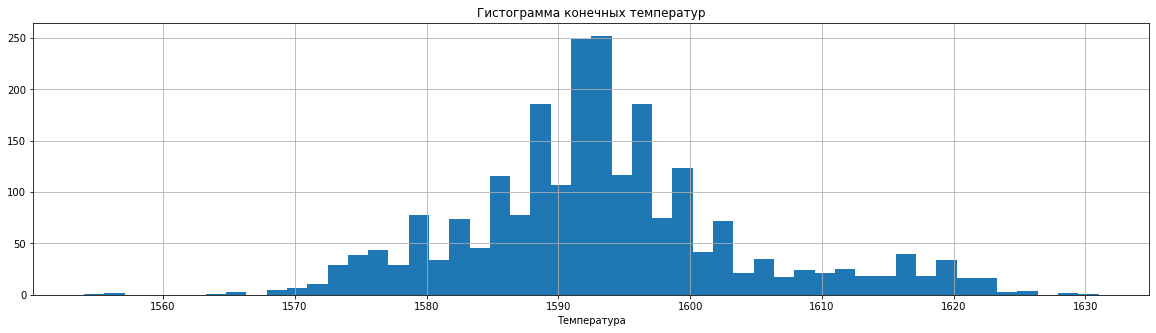

In [35]:
q3 = full['last_temperature'].quantile(0.75)
q1 =full['last_temperature'].quantile(0.25)
iqr = q3 - q1
upper = q3 + 3 * iqr
lower = q1 - 3 * iqr

full = full.query('@lower <= last_temperature <= @upper')
full['last_temperature'].hist(bins=50, figsize=(20, 5))
plt.title('Гистограмма конечных температур')
plt.xlabel('Температура')
plt.show()

# Обучение модели

Обучим несколько моделей и посмотрим какая справится лучше всего.

In [36]:
X = full.drop('last_temperature', axis=1)
y = full['last_temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [37]:
models_params = {
    LinearRegression() : dict(),
    ElasticNet(random_state=24) : dict(alpha=stats.uniform(0, 1), l1_ratio=stats.uniform(0, 1)),
    DecisionTreeRegressor(random_state=24) : dict(max_depth=range(1, 101), min_samples_split=stats.loguniform(1e-5, 1e-2)),
    LGBMRegressor(random_state=24) : dict(max_depth=range(-1, 201), num_leaves=range(5, 101), n_estimators=range(1, 201)),
    DummyRegressor() : dict(strategy=['mean', 'median'])
}

In [38]:
trained_models=[]
for model, params in models_params.items():
    timer = time.time()
    random_search = RandomizedSearchCV(model, param_distributions=params, scoring='neg_mean_absolute_error', random_state=24, n_iter=100, cv=5)
    random_search.fit(X_train, y_train)
    timer = time.time() - timer
    print(f'Обучение модели {model} заняло {timer:.2f} сек или {(timer / 60):.2f} мин')
    trained_models.append(random_search)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Обучение модели LinearRegression() заняло 0.55 сек или 0.01 мин
Обучение модели ElasticNet(random_state=24) заняло 2.54 сек или 0.04 мин
Обучение модели DecisionTreeRegressor(random_state=24) заняло 7.00 сек или 0.12 мин
Обучение модели LGBMRegressor(random_state=24) заняло 44.01 сек или 0.73 мин
Обучение модели DummyRegressor() заняло 0.02 сек или 0.00 мин


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# Анализ моделей

In [39]:
def model_scoring(model, X_test, y_test): # функция для выведения оценки модели.
    print('Модель', model.best_estimator_)
    print('Лучший MAE при кросс-валидации =', -model.best_score_)
    predicted = model.predict(X_test)
    print(f'MAE на тестовой выборке = {mean_absolute_error(y_test, predicted)}')
    
    plt.figure(figsize=(18,6))
    y_test.sort_index().plot(label='Реальные')
    predicted = pd.Series(predicted, index=y_test.index)
    predicted.sort_index().plot(label='Предсказываемые')
    plt.title('Результаты обучения модели')
    plt.xlabel('Номер партии')
    plt.ylabel('Температура')
    plt.legend()
    plt.show()
    
    print('\n\n')
    return None

Модель LinearRegression()
Лучший MAE при кросс-валидации = 6.487557477158968
MAE на тестовой выборке = 6.355545170445042


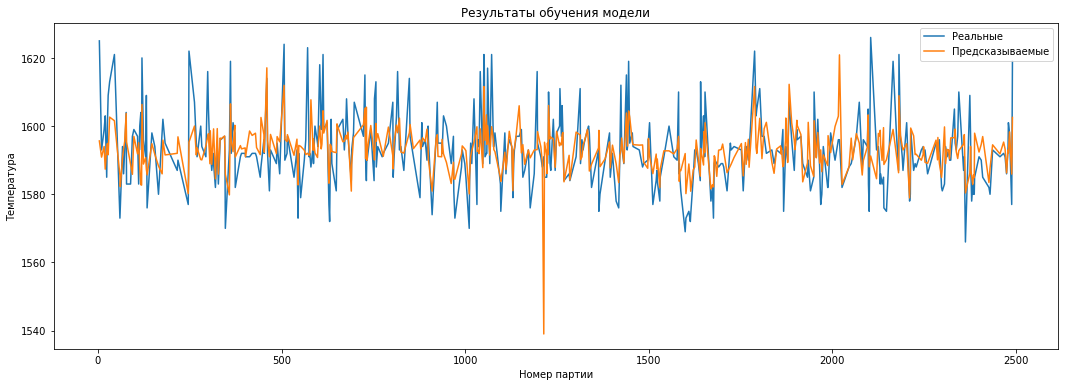




Модель ElasticNet(alpha=0.11409656487218656, l1_ratio=0.031438805443634976,
           random_state=24)
Лучший MAE при кросс-валидации = 6.487648062967163
MAE на тестовой выборке = 6.355482744771066


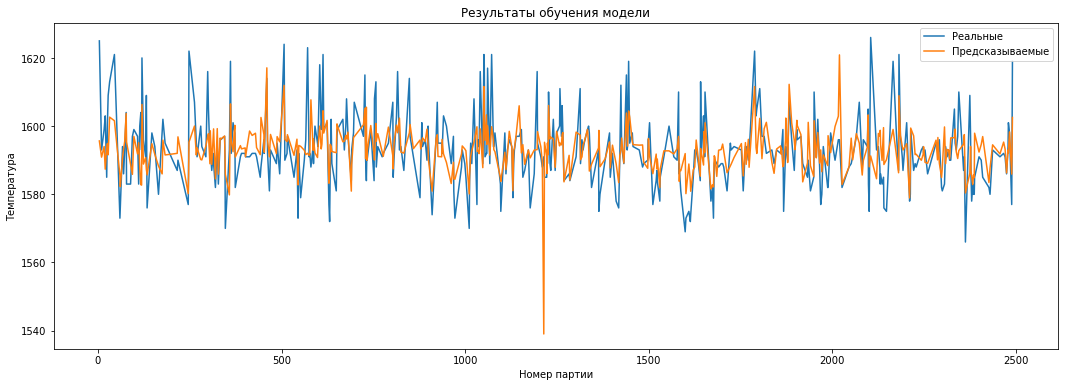




Модель DecisionTreeRegressor(max_depth=6, min_samples_split=0.00012161689473078051,
                      random_state=24)
Лучший MAE при кросс-валидации = 7.044677864841248
MAE на тестовой выборке = 6.843756260148322


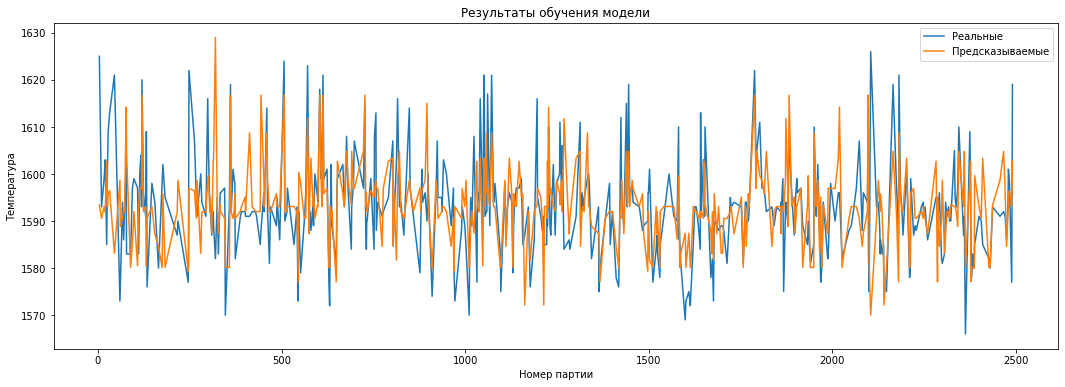




Модель LGBMRegressor(max_depth=104, n_estimators=35, num_leaves=24, random_state=24)
Лучший MAE при кросс-валидации = 5.950271700526448
MAE на тестовой выборке = 5.8902772440555715


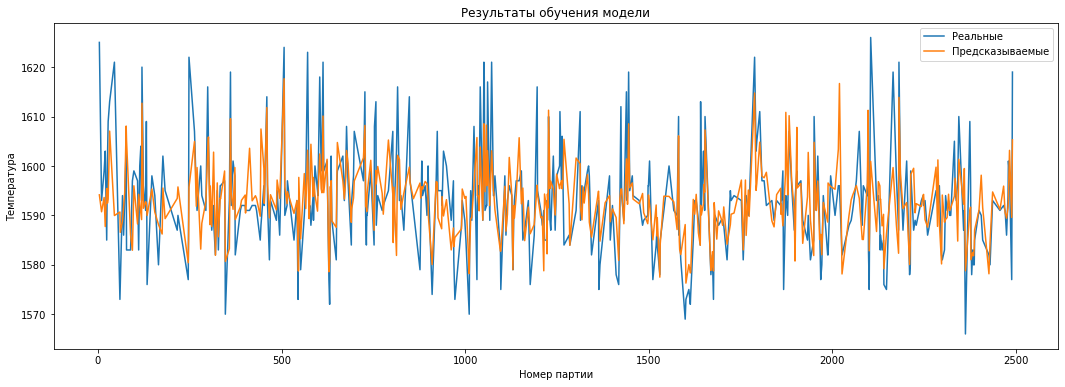




Модель DummyRegressor(strategy='median')
Лучший MAE при кросс-валидации = 7.954177897574124
MAE на тестовой выборке = 7.560344827586207


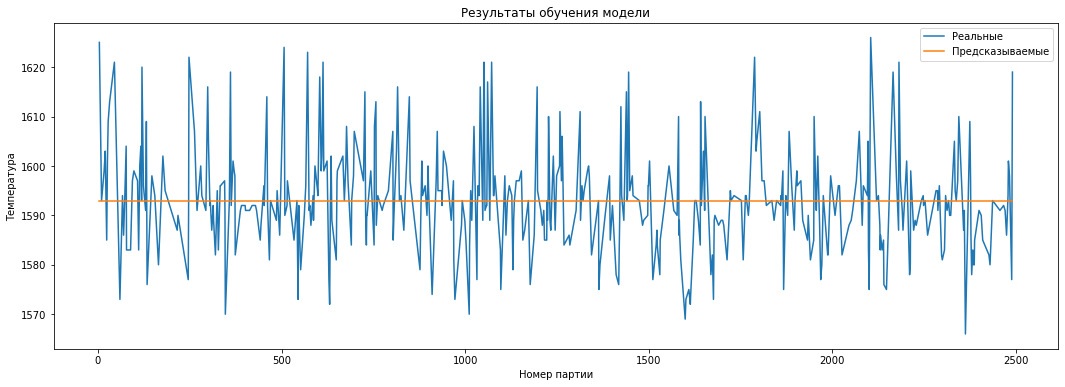

In [40]:
for model in trained_models:
    model_scoring(model, X_test, y_test)

По результатам видно, что все модели превзошли Dummy модель, что уже хорошо. Однако, лучшей моделью оказался LGBMRegressor. Его метрика MAE на тестовой выборке составила 5.89 градусов, а это уже превосходит требования проекта по метрике (6.0).

Посмотрим какие из параметров оказались для модели самыми полезными.

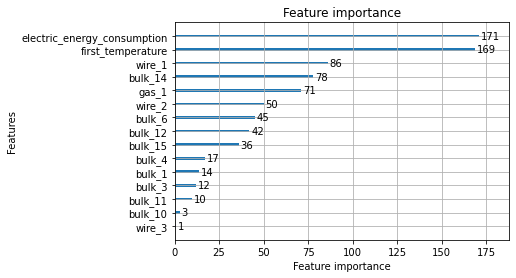

In [41]:
plot_importance(trained_models[-2].best_estimator_)
plt.show()

Пятерку самых значительных для определения конечной температуры стали факторов составляют:
1. Полное энергопотребление на партию
2. Начальная температура стали
3. Объем проволоки wire_1
4. Объем сыпучего вещества bulk_14
5. Объем продуваемого газа

# Вывод

В ходе работы были построены несколько моделей для предсказания температуры стали в конце цикла плавки.

Для этого часть характеристик процесса была сгруппированы и преобразована в одну новую характеристику - полное энергопотребление на партию. Другими основными параметрами для модели послужили значительные по объему добавки к стали (как сыпучие, так и виде проволоки), объем продуваемого инертного газа, и начальная температура стали.

Лучшей моделью для предсказания конечной температуры стали оказалась модель LGBMRegressor, она дала метрику MAE = 5.89 градуса и прошла проверку на адекватность.

Также были выявлены самые важные факторы влияющие на конечную температуру стали. А именно: полное энергопотребление на партию, начальная температура стали, объем проволоки wire_1, объем сыпучего вещества bulk_14, объем продуваемого газа.